# **KF on existing predictions**

In [80]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 10,10

import json
import os

from filterpy.kalman import KalmanFilter

#### Path setup

In [92]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [112]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(datasets_path, all_datasets[1], "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(datasets_path, all_datasets[1], "info_eval.csv"))
#eval_info = eval_info.drop([0]) # First route  does not work
#eval_info['cumsum'] = eval_info['cumsum'] - 2

In [114]:
def plot_route_df(route):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    plt.plot(route['gt_pc1centers_x'], route['gt_pc1centers_y'], '-ok',color='black')
    plt.plot(route['gt_pc1centers_x']+route['pred_trans_x'], route['gt_pc1centers_y']+route['pred_trans_y'], '-ok', color='orange')

#### Split into different route/tables

In [115]:
predictions

,pred_trans_x,pred_trans_y,pred_angles,gt_trans_x,gt_trans_y,gt_angles,gt_pc1centers_x,gt_pc1centers_y,gt_pc1angles
0,-1.250951,0.161196,-0.006715,-1.268572,0.110685,-0.015054,21.388956,16.689873,1.599856
1,-1.248904,0.096816,-0.007090,-1.268572,0.110689,-0.015054,20.120384,16.800558,1.584802
2,-1.117925,0.114607,-0.010809,-1.276125,0.078547,-0.002452,25.918905,16.165125,1.628654
3,-1.327577,0.080942,-0.004132,-1.276123,0.078548,-0.002451,24.642780,16.243671,1.626202
4,-1.071834,0.131260,-3.080835,-1.276123,0.078547,-0.002452,23.366657,16.322220,1.623751
...,...,...,...,...,...,...,...,...,...
12067,-2.266991,0.103149,-0.047184,-1.754080,0.017648,-0.005763,15.719444,6.739439,1.617629
12068,-1.782968,-0.002613,-0.052496,-1.754082,0.017648,-0.005763,13.965364,6.757087,1.611866
12069,-1.890659,0.033930,-0.003134,-1.754080,0.017648,-0.005763,12.211283,6.774735,1.606103
12070,-1.699435,0.069603,0.001575,-1.754081,0.017648,-0.005763,10.457203,6.792383,1.600340


In [99]:
def routes_to_dict(eval_info, predictions):
    routes = dict()
    n_routes = eval_info.shape[0]
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        end_i = start_i + current['n_points']
        current_pred = predictions.iloc[start_i:end_i]
        
        routes[current['name']] = current_pred
            
    return routes

In [117]:
routes = routes_to_dict(eval_info, predictions)

In [118]:
eval_info

,name,type,first_point,n_points,cumsum
0,2_0,E,28463,2,0
1,2_1,E,28465,6,2
2,2_2,E,28471,10,8
3,2_4,E,28481,92,18
4,2_5,E,28573,34,110
...,...,...,...,...,...
232,18_16,E,40419,25,11956
233,18_17,E,40444,18,11981
234,18_18,E,40462,16,11999
235,18_19,E,40478,40,12015


#### Plot single tables

In [119]:
i = 10

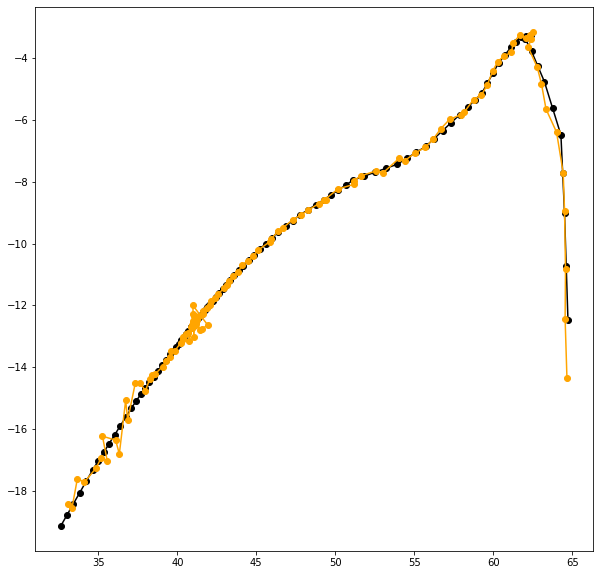

In [135]:
plot_route_df(routes[list(routes.keys())[i]])
i += 1

#### Run simple evaluation

In [136]:
def compute_error_route(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    route.loc[:,'error_x'] = (route['pred_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'error_y'] = (route['pred_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'error_angle'] = ((route['pred_angles']-route['gt_angles'])*180)**2
    # mean
    x_e = np.mean(route['error_x'])
    y_e = np.mean(route['error_y'])
    a_e = np.mean(route['error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [137]:
def compute_error(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        trans, angle = compute_error_route(route)
        error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['error_trans'], eval_info['error_angle'] = error[:,0], error[:,1]
    # Remember that -2 in the routes index? The first route had 0 points so
    # it is a NaN. TODO: Investigate this
    #eval_info = eval_info.drop([0], axis=0)
    
    trans_error = np.mean(eval_info['error_trans'])
    angle_error = np.mean(eval_info['error_angle'])
    
    print(f"RMSE trans: {trans_error}\nRMSE angle: {angle_error}")
    
    return trans_error, angle_error

In [138]:
compute_error(eval_info, routes)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


RMSE trans: 0.17477645190695645
RMSE angle: 200.20328126888592


(0.17477645190695645, 200.20328126888592)

#### Run KF on single table

In [140]:
def run_kf_predictions(route):
    """ Runs Kalman Filter on the predictions 
        Params:
        -
        -
    """
    # Tracker object initialization
    position = route.iloc[0,0:3].values
    tracker = KalmanMotionTracker(position)
    
    # Container for the KF data
    kf = np.zeros((route.shape[0],3))
    kf[0,:] = route.iloc[0,0:3]
    # We feed from 0 to N observations to the filter
    for i in range(1, route.shape[0]):
        position = route.iloc[i,0:3].values
        tracker.update(position)
        # We store the inmediate pose
        #predictions = tracker.predict().ravel()
        predictions = tracker.get_state()
        kf[i,:] = predictions[:3]
        
    return kf

In [141]:
for i in range(len(routes)):
    
    route = routes[list(routes.keys())[i]]
    
    kf_pred = run_kf_predictions(route)
    
    route[['kf_trans_x','kf_trans_y', 'kf_angle']] = pd.DataFrame(kf_pred, index=route.index)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:2960: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [199]:
def create_arrow(posx, posy, angle, color, norm):
    return patches.FancyArrow(posx, posy, norm*math.cos(angle), norm*math.sin(angle), width=0.01, head_width=0.05, head_length=0.06, color=color)

In [200]:
mean_dist = (abs(np.mean(route['gt_trans_x']))**2+abs(np.mean(route['gt_trans_y']))**2)**0.5

In [215]:
def plot_route_df_kf(name, routes, eval_info):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    route = routes[name]
    route_info = eval_info.loc[eval_info['name'] == name]
    nn_rmse = route_info['error_trans'].values[0]
    kf_rmse = route_info['kf_error_trans'].values[0]
    
    mean_dist = (abs(np.mean(route['gt_trans_x']))**2+np.mean(route['gt_trans_y'])**2)**0.5
    print(mean_dist)
    
    fig, ax = plt.subplots()
    
    # Add the position data points
    gt_p = [route['gt_pc1centers_x'], route['gt_pc1centers_y']]
    pc_p = [gt_p[0]+route['gt_trans_x'],gt_p[1]+route['gt_trans_y']]
    pr_p = [gt_p[0]+route['pred_trans_x'], gt_p[1]+route['pred_trans_y']]
    kf_p = [gt_p[0]+route['kf_trans_x'], gt_p[1]+route['kf_trans_y']]
    
    # Add the angle data points
    gt_a = route['gt_pc1angles']
    pc_a = gt_a+route['gt_angles']
    pr_a = gt_a+route['pred_angles']
    kf_a = gt_a+route['kf_angle']
    
    ax.plot(pc_p[0], pc_p[1], '-ok',color='black')
    ax.plot(pr_p[0], pr_p[1], '-ok', color='orange')
    ax.plot(kf_p[0], kf_p[1], '-ok', color='red')
    
    # Add the arrows
    for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
        ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
    for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
        ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
    for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
        ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    
    # Set title to the plot
    ax.set_title(f"route: {name} nn_rmse: {nn_rmse} kf_rmse: {kf_rmse}", size=20)
   

In [206]:
route

,pred_trans_x,pred_trans_y,pred_angles,gt_trans_x,gt_trans_y,gt_angles,gt_pc1centers_x,gt_pc1centers_y,gt_pc1angles,error_x,error_y,error_angle,kf_trans_x,kf_trans_y,kf_angle,kf_error_x,kf_error_y,kf_error_angle
12055,-1.843741,0.057057,0.077516,-1.721062,0.088367,-0.000085,37.482900,5.949889,1.593846,0.015050,0.000980,195.111693,-1.843741,0.057057,0.077516,0.015050,0.000980,195.111693
12056,-1.664149,0.051464,-0.007261,-1.721062,0.088368,-0.000086,35.761837,6.038256,1.593761,0.003239,0.001362,1.668137,-1.680475,0.051973,0.000446,0.001647,0.001325,0.009160
12057,-1.715442,0.049894,-0.005519,-1.874142,0.058147,-0.000145,34.040775,6.126624,1.593675,0.025185,0.000068,0.935564,-1.697126,0.050983,-0.002394,0.031334,0.000051,0.163942
12058,-1.872425,0.127592,-3.084169,-1.874147,0.058148,-0.000146,32.166634,6.184771,1.593530,0.000003,0.004822,308162.804540,-1.753674,0.075695,-3.124691,0.014514,0.000308,316314.092596
12059,-1.823168,0.071574,3.017445,-1.874144,0.058147,-0.000145,30.292486,6.242919,1.593384,0.002599,0.000180,295029.536016,-1.770624,0.074690,3.124092,0.010716,0.000274,316251.799926
12060,-1.839218,0.055244,-3.080592,-1.874146,0.058148,-0.000145,28.418343,6.301066,1.593239,0.001220,0.000008,307448.628728,-1.784074,0.070877,-3.143701,0.008113,0.000162,320174.972516
12061,-1.811993,0.071031,-3.081695,-1.874144,0.058148,-0.000146,26.544197,6.359214,1.593094,0.003863,0.000166,307668.507217,-1.788651,0.070902,-3.133536,0.007309,0.000163,318107.475933
12062,-1.774350,0.069530,-3.080099,-1.790123,0.064415,0.004936,24.670053,6.417362,1.592948,0.000249,0.000026,308365.086620,-1.786636,0.070709,-3.126010,0.000012,0.000040,317611.389058
12063,-1.657584,0.046309,-0.050334,-1.790121,0.064415,0.004937,22.879930,6.481777,1.597884,0.017566,0.000328,98.977556,-1.770704,0.067697,0.007445,0.000377,0.000011,0.203842
12064,-1.532305,0.053299,0.005136,-1.790121,0.064416,0.004936,21.089810,6.546192,1.602821,0.066469,0.000124,0.001302,-1.744506,0.066115,0.007191,0.002081,0.000003,0.164830


In [202]:
i=0

0.43202161301967923


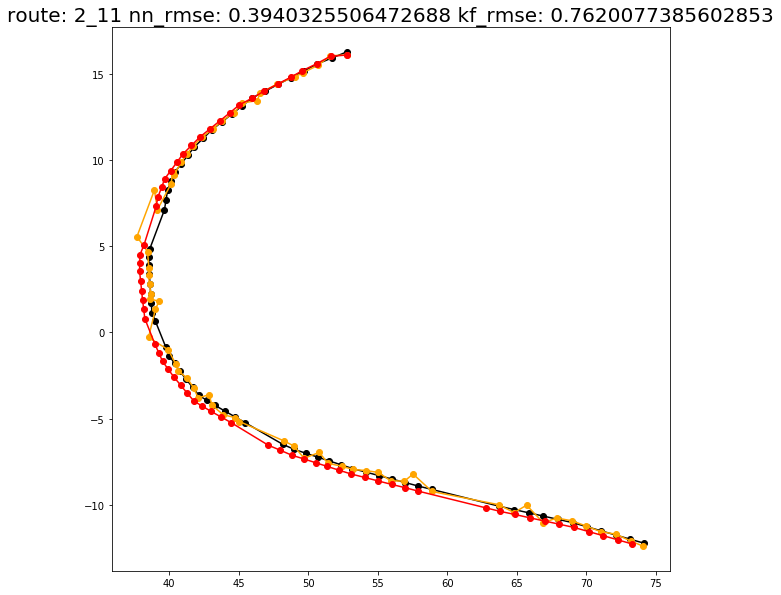

In [216]:
plot_route_df_kf(list(routes.keys())[i], routes, eval_info)
i += 1

#### Run simple evaluation again

In [146]:
def compute_error_route_kf(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    route.loc[:,'kf_error_x'] = (route['kf_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'kf_error_y'] = (route['kf_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'kf_error_angle'] = ((route['kf_angle']-route['gt_angles'])*180)**2
    # mean
    x_e = np.mean(route['kf_error_x'])
    y_e = np.mean(route['kf_error_y'])
    a_e = np.mean(route['kf_error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [147]:
def compute_error_kf(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        # This is bc there are some routes without the kf columns
        if route.shape[0] == 0:
            error[i,:] = [np.nan, np.nan]
        else:
            trans, angle = compute_error_route_kf(route)
            error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['kf_error_trans'], eval_info['kf_error_angle'] = error[:,0], error[:,1]
    
    
    trans_error = np.mean(eval_info['kf_error_trans'])
    angle_error = np.mean(eval_info['kf_error_angle'])
    
    print(f"RMSE trans: {trans_error}\nRMSE angle: {angle_error}")
    
    return trans_error, angle_error

In [148]:
compute_error_kf(eval_info, routes)

RMSE trans: 0.18493094779187916
RMSE angle: 281.51206932983695


(0.18493094779187916, 281.51206932983695)

#### Kalman filter implementation

In [139]:
class KalmanMotionTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as translation.
    """
    def __init__(self, position):
        """
        Initialises a tracker using initial position.

        KF Instance variables:
          x : ndarray (dim_x, 1), default = [0,0,0…0] filter state estimate
          P : ndarray (dim_x, dim_x), default eye(dim_x) covariance matrix
          Q : ndarray (dim_x, dim_x), default eye(dim_x) Process uncertainty/noise
          R : ndarray (dim_z, dim_z), default eye(dim_x) measurement uncertainty/noise
          H : ndarray (dim_z, dim_x) measurement function
          F : ndarray (dim_x, dim_x) state transistion matrix
          B : ndarray (dim_x, dim_u), default 0 control transition matrix
        """
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=5, dim_z=3)   

        self.kf.x[:3] = position.reshape((3, 1))
        self.kf.P[3:,3:] *= 1000. #state uncertainty, give high uncertainty to the unobservable initial velocities, covariance matrix
        self.kf.P *= 10.
        self.kf.Q[3:,3:] *= 0.01


        self.kf.F = np.array([[1,0,0,1,0],      # state transition matrix
                              [0,1,0,0,1],
                              [0,0,1,0,0],
                              [0,0,0,1,0],  
                              [0,0,0,0,1]])

        self.kf.H = np.array([[1,0,0,0,0],      # measurement function,
                              [0,1,0,0,0],
                              [0,0,1,0,0]])


        # self.kf.R[0:,0:] *= 10.   # measurement uncertainty

        self.time_since_update = 0
        self.history = []
        self.hits = 1           # number of total hits including the first detection
        self.hit_streak = 1     # number of continuing hit considering the first detection
        self.first_continuing_hit = 1
        self.still_first = True
        self.age = 0

    def update(self, position): 
        """ 
        Updates the state vector with observed position.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1          # number of continuing hit
        if self.still_first:
            self.first_continuing_hit += 1      # number of continuing hit in the fist time

        ######################### orientation correction NEEDED?
        if self.kf.x[2] >= np.pi: self.kf.x[2] -= np.pi * 2    # make the theta still in the range
        if self.kf.x[2] < -np.pi: self.kf.x[2] += np.pi * 2

        new_theta = position[2]
        if new_theta >= np.pi: new_theta -= np.pi * 2    # make the theta still in the range
        if new_theta < -np.pi: new_theta += np.pi * 2
        position[2] = new_theta

        predicted_theta = self.kf.x[2]
        if abs(new_theta - predicted_theta) > np.pi / 2.0 and abs(new_theta - predicted_theta) < np.pi * 3 / 2.0:     # if the angle of two theta is not acute angle
            self.kf.x[2] += np.pi       
            if self.kf.x[2] > np.pi: self.kf.x[3] -= np.pi * 2    # make the theta still in the range
            if self.kf.x[2] < -np.pi: self.kf.x[3] += np.pi * 2

        # now the angle is acute: < 90 or > 270, convert the case of > 270 to < 90
        if abs(new_theta - self.kf.x[2]) >= np.pi * 3 / 2.0:
            if new_theta > 0: self.kf.x[2] += np.pi * 2
            else: self.kf.x[2] -= np.pi * 2

        #########################

        self.kf.update(position)

        if self.kf.x[3] >= np.pi: self.kf.x[3] -= np.pi * 2    # make the theta still in the range
        if self.kf.x[3] < -np.pi: self.kf.x[3] += np.pi * 2

    def predict(self):       
        """
        Advances the state vector and returns the predicted movement estimate.
        """
        self.kf.predict()      
        if self.kf.x[3] >= np.pi: self.kf.x[3] -= np.pi * 2
        if self.kf.x[3] < -np.pi: self.kf.x[3] += np.pi * 2

        self.age += 1
        if(self.time_since_update>0):
            self.hit_streak = 0
            self.still_first = False
        self.time_since_update += 1
        self.history.append(self.kf.x)
        
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return self.kf.x[:3].reshape((3, ))